# I. Preparation

In [1]:
with open("../names.txt", "r") as fp:
    words = fp.read().splitlines()

In [2]:
len(words)

32033

In [3]:
alphabet = sorted(list(set(ch for w in words for ch in w)))
stoi = {ch: i + 1 for i, ch in enumerate(alphabet)}
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()}

# II. A Step-to-Step Forward

### 1. Dataset

In [4]:
import torch

block_size = 3  # context window

X, Y = [], []

for w in words[:5]:
    print(w)
    seq = ["."] * block_size
    for ch in w + ".":
        next_token = ch

        X.append([stoi[c] for c in seq])
        Y.append(stoi[next_token])

        print(f"{''.join(seq)} --> {next_token}")
        seq = seq[1:] + [ch]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [5]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

### 2. Embedding

In [56]:
import torch

g = torch.Generator().manual_seed(1337)
C = torch.randn((27, 2), generator=g)

In [57]:
C

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433],
        [ 1.3488, -0.1396],
        [ 0.2858,  0.9651],
        [-2.0371,  0.4931],
        [ 1.4870,  0.5910],
        [ 0.1260, -1.5627],
        [-1.1601, -0.3348],
        [ 0.4478, -0.8016],
        [ 1.5236,  2.5086],
        [-0.6631, -0.2513],
        [ 1.0101,  0.1215],
        [ 0.1584,  1.1340],
        [ 2.7630, -1.7465],
        [ 0.4109, -0.2422],
        [ 0.4208,  0.2776],
        [-0.4440, -0.3797],
        [ 1.6097, -0.4032],
        [-0.2749,  1.4738],
        [ 0.0688,  1.3327],
        [-0.9523,  0.2588]])

In [58]:
# pick one row
C[0]

tensor([ 0.1808, -0.0700])

In [59]:
# pick 3 rows
C[[0, 1, 2]]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255]])

In [60]:
X[0]

tensor([0, 0, 0])

In [61]:
# pick the first row, 3 times
C[X[0]]

tensor([[ 0.1808, -0.0700],
        [ 0.1808, -0.0700],
        [ 0.1808, -0.0700]])

In [63]:
# equivalent of using one hot encoding then matmul by C.
# Direct indexing is faster than one hot encoding followed by matmul
import torch.nn.functional as F

assert torch.allclose(F.one_hot(X[0], num_classes=27).float() @ C, C[X[0]])

In [65]:
emb = C[X]

In [66]:
emb.shape

torch.Size([32, 3, 2])

Two way to understand the emb.

1) We have X as size of (num_examples, block_size), say (32, 3), each element in a row representing an index in our alphabet / vocab. Now we replace each of those indexes with a tuple of 2 floating numbers, making it a 3d tensor (Stretching it in the 3rd dimension). How these tuples are found is by looking up in the table C and choose the corresponding rows using the indexes we have in X. Thus the indexes must be within range [0, row_of_C). This is actually what one-hot encoding followed by matmul is doing.

2) We have C as size of (len(vocab), num_embeddings), say (27, 2). Now we index C with a number of arrays. One element in an array gives one row from C (element being used as row index in C). Thus an array of length 3 gives 3 rows from C. And 32 arrays gives 32 of 3 rows from C (each row of C has 2 floating numbers). This is what C[X] gives.

### 3. Forward

#### 1st Layer

In [68]:
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)

In [69]:
emb @ W1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

> "view" is much faster than "concatenation" since the former doesn't involve memory allocation / movement.

In [70]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [71]:
emb.view((32, 6)).shape

torch.Size([32, 6])

In [72]:
emb.view((-1, 6)).shape

torch.Size([32, 6])

In [74]:
assert torch.allclose(torch.cat(torch.unbind(emb, dim=1), dim=1), emb.view((-1, 6)))

In [76]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)

#### 2nd Layer

In [79]:
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)

In [78]:
h.shape

torch.Size([32, 100])

In [80]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

### 4. Loss

In [83]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [84]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [87]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [88]:
# Find corresponding outputs
# We want these values to be as close to 1 as possible. (1 for the indexes specified by Y, and 0 for others)
probs[torch.arange(32), Y]

tensor([2.4039e-05, 6.9315e-09, 1.5309e-12, 9.6004e-02, 1.0590e-03, 3.7566e-05,
        7.6202e-17, 1.1234e-08, 6.5054e-10, 2.2743e-06, 3.2300e-11, 6.5860e-07,
        6.1857e-05, 1.2146e-05, 9.2159e-05, 3.0626e-08, 1.7781e-05, 9.6572e-11,
        9.5115e-09, 3.1579e-10, 2.1045e-03, 1.3969e-05, 1.1030e-03, 1.4930e-03,
        2.3033e-12, 5.8219e-06, 1.2322e-12, 4.6311e-12, 5.9948e-01, 1.6755e-11,
        8.2791e-07, 9.8751e-18])

In [95]:
# NLL
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(16.4821)

In [93]:
# using cross entropy
import torch.nn.functional as F

# Cross Entropy == Softmax + NLL
F.cross_entropy(logits, Y, reduction="mean")

tensor(16.4821)

In [ ]:
assert -probs[torch.arange(32), Y].log().mean() == F.cross_entropy(logits, Y, reduction="mean")

# III. Training Loop

### 1. Overfitting a small dataset

In [96]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [98]:
import torch

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100,), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [101]:
sum(p.nelement() for p in parameters)

3481

In [110]:
import torch
import torch.nn.functional as F

for _ in range(100):
    # forward
    emb = C[X]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y, reduction="mean")

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.2
    for p in parameters:
        p.data += -learning_rate * p.grad

In [111]:
print(loss.item())

0.2890501022338867


After training 100 times, the loss is relatively low.

Comparing the indexes of max number in logits and the label Y, we see some values are equal, which is good. Others are not equal, basically because
the starting window "..." can be followed by different characters (the 1st character in names).

We are able to overfit our small dataset.

In [112]:
logits.max(dim=1)

torch.return_types.max(
values=tensor([12.6529, 14.9630, 19.5675, 18.9386, 15.0829, 12.6529, 14.6667, 13.2099,
        14.4161, 16.1723, 14.4680, 17.8463, 12.6529, 14.6796, 15.6007, 18.2783,
        12.6529, 14.4396, 12.6102, 16.1019, 18.0916, 12.2037,  9.3557,  8.6684,
        14.3760, 12.6529, 13.2450, 14.7947, 12.4688, 14.6582, 17.7984, 13.8765],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [113]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

### 2. Use Full Dataset

In [116]:
import torch

block_size = 3  # context window

X, Y = [], []

for w in words:
    seq = ["."] * block_size
    for ch in w + ".":
        next_token = ch

        X.append([stoi[c] for c in seq])
        Y.append(stoi[next_token])

        seq = seq[1:] + [ch]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [117]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [133]:
import torch

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100,), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

3481

In [119]:
import torch
import torch.nn.functional as F

for _ in range(10):
    # forward
    emb = C[X]  # (228146, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (228146, 100)
    logits = h @ W2 + b2  # (228146, 27)
    loss = F.cross_entropy(logits, Y, reduction="mean")
    print(loss.item())

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.2
    for p in parameters:
        p.data += -learning_rate * p.grad

19.505229949951172
15.998201370239258
14.088128089904785
12.687946319580078
11.562962532043457
10.761611938476562
10.168497085571289
9.645676612854004
9.168879508972168
8.732568740844727


# IV. Improvements

### 1. Mini-batches

To speed up the training

In [123]:
import torch
import torch.nn.functional as F

mini_batch_size = 32

for _ in range(100):
    mini_batch_idxs = torch.randint(0, X.shape[0], (mini_batch_size,))

    # forward
    emb = C[X[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[mini_batch_idxs], reduction="mean")
    print(loss.item())

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.2
    for p in parameters:
        p.data += -learning_rate * p.grad

8.84489917755127
7.695725440979004
9.008890151977539
6.752209663391113
6.996969223022461
7.82224702835083
7.259411811828613
7.175405979156494
5.68449068069458
9.103703498840332
4.7281646728515625
7.236924171447754
5.889965534210205
7.137609481811523
5.250339984893799
4.490716457366943
5.403454780578613
4.920587539672852
5.861929416656494
5.88117790222168
4.368228912353516
5.74033260345459
5.000261306762695
3.86448073387146
4.922882080078125
4.692350387573242
5.426079273223877
5.8588690757751465
3.693840980529785
4.488279819488525
4.296844959259033
4.220454216003418
5.204118728637695
4.927313327789307
3.965378761291504
3.399885416030884
4.142465114593506
3.706012010574341
3.7555181980133057
4.458453178405762
3.547295331954956
3.815459966659546
4.450170040130615
3.478888750076294
3.012373208999634
4.329896926879883
4.214814186096191
3.5062105655670166
4.584789752960205
3.793393850326538
3.9101641178131104
4.366077423095703
4.275130271911621
4.228752136230469
3.9915404319763184
2.88588833

### 2. Find a Good Learning Rate

#### a. find lower and upper bounds

> Remember to reset all params every time

In [125]:
# try to find a lower bound of learning rate
import torch
import torch.nn.functional as F

mini_batch_size = 32

for _ in range(100):
    mini_batch_idxs = torch.randint(0, X.shape[0], (mini_batch_size,))

    # forward
    emb = C[X[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[mini_batch_idxs], reduction="mean")
    print(loss.item())

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.001
    for p in parameters:
        p.data += -learning_rate * p.grad

21.0896053314209
18.433286666870117
20.6600284576416
19.514856338500977
20.975255966186523
20.26926612854004
16.18210792541504
19.663976669311523
19.41305160522461
19.074960708618164
22.90711784362793
18.771242141723633
21.474395751953125
17.368650436401367
19.715286254882812
18.850183486938477
23.291067123413086
19.795001983642578
18.018299102783203
18.04878044128418
17.870277404785156
19.618030548095703
17.93292236328125
15.869194030761719
24.829757690429688
16.588769912719727
19.067941665649414
15.41004753112793
18.853946685791016
21.642263412475586
19.272842407226562
19.5616397857666
18.387493133544922
17.117799758911133
14.418325424194336
17.960102081298828
19.925535202026367
18.419700622558594
18.808177947998047
17.047611236572266
13.893145561218262
18.2453556060791
17.363630294799805
20.1563777923584
14.582698822021484
15.721273422241211
18.15259552001953
18.60744285583496
17.836734771728516
19.616975784301758
18.15584945678711
19.708534240722656
15.566906929016113
16.4866600036

In [127]:
# try to find a upper bound for learning rate
import torch
import torch.nn.functional as F

mini_batch_size = 32

for _ in range(100):
    mini_batch_idxs = torch.randint(0, X.shape[0], (mini_batch_size,))

    # forward
    emb = C[X[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[mini_batch_idxs], reduction="mean")
    print(loss.item())

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 1
    for p in parameters:
        p.data += -learning_rate * p.grad

20.751842498779297
12.78869342803955
12.110481262207031
12.403935432434082
13.512938499450684
12.632973670959473
12.124969482421875
10.96733283996582
8.796321868896484
10.10569953918457
8.670614242553711
11.916468620300293
9.748819351196289
11.622769355773926
9.601882934570312
9.563347816467285
7.015271186828613
10.970406532287598
8.862371444702148
7.854324817657471
7.666099548339844
7.608391284942627
8.905035972595215
6.536152362823486
7.062322616577148
7.7388596534729
9.4306058883667
9.79012680053711
8.213879585266113
11.265913009643555
11.048141479492188
9.686266899108887
10.819252967834473
8.757780075073242
8.912065505981445
8.85029411315918
6.5859808921813965
8.883039474487305
10.130281448364258
9.720575332641602
11.775057792663574
8.584440231323242
9.631266593933105
11.079575538635254
9.630969047546387
10.52729606628418
7.871476173400879
6.749454975128174
7.608766078948975
6.955246925354004
7.55897855758667
9.166986465454102
12.256085395812988
9.22571849822998
8.694846153259277
7

#### b. Grid search

In [129]:
lr_exp = torch.linspace(-3, 0, 1000)
lrs = 10**lr_exp
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

#### c. Track loss to learning rate

In [134]:
# Track loss to learning rate
import torch
import torch.nn.functional as F

mini_batch_size = 32

lr_list = []
loss_list = []

for epoch in range(1000):
    mini_batch_idxs = torch.randint(0, X.shape[0], (mini_batch_size,))

    # forward
    emb = C[X[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[mini_batch_idxs], reduction="mean")

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = lrs[epoch]
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    loss_list.append(loss.item())
    lr_list.append(learning_rate)

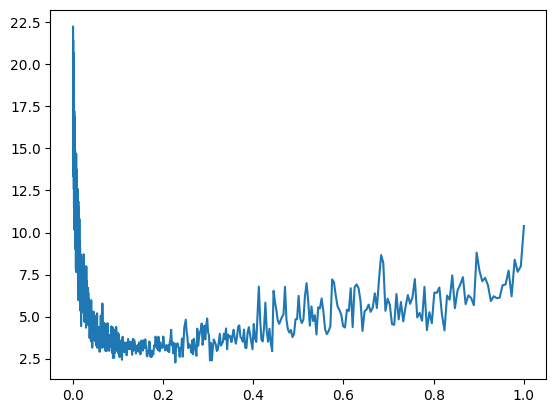

In [135]:
# We can see the best learning rate is somewhere between 0.0 and 0.2

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(lr_list, loss_list)

#### d. Track loss to exp of learning rate

In [136]:
# Track loss to expoential of learning rate
import torch
import torch.nn.functional as F

mini_batch_size = 32

lr_list = []
loss_list = []

for epoch in range(1000):
    mini_batch_idxs = torch.randint(0, X.shape[0], (mini_batch_size,))

    # forward
    emb = C[X[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[mini_batch_idxs], reduction="mean")

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = lrs[epoch]
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    loss_list.append(loss.item())
    lr_list.append(torch.log10(learning_rate).item())

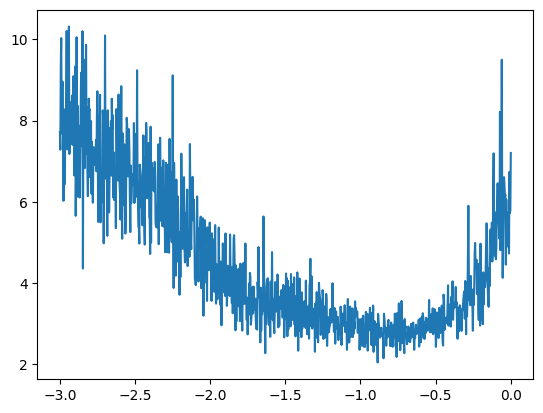

In [137]:
# We can see the exponential of the best learning rate is somewhere -1.0
# Thus gives us the best learning rate as 10 ** -1.0 == 0.1

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(lr_list, loss_list)

### 3. Split the Dataset

We should only evaluate it on the validation dataset

In [140]:
import torch
import typing as tp

block_size = 3  # context window


def build_dataset(corpse: tp.List[str]):
    X, Y = [], []

    for w in corpse:
        seq = ["."] * block_size
        for ch in w + ".":
            next_token = ch

            X.append([stoi[c] for c in seq])
            Y.append(stoi[next_token])

            seq = seq[1:] + [ch]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [141]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [142]:
Xval.shape, Yval.shape

(torch.Size([22767, 3]), torch.Size([22767]))

In [143]:
Xtest.shape, Ytest.shape

(torch.Size([22799, 3]), torch.Size([22799]))

In [144]:
import torch

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100,), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

print(f"Numberr of parameters: {sum(p.nelement() for p in parameters)}")

Numberr of parameters: 3481


In [146]:
import torch
import torch.nn.functional as F

mini_batch_size = 32

for _ in range(30000):
    mini_batch_idxs = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward
    emb = C[Xtr[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[mini_batch_idxs], reduction="mean")

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad

In [148]:
# loss on training set and validation set are almost equal
# meaning that our model is underfitting.
import torch
import torch.nn.functional as F


def forward(input):
    emb = C[input]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    return logits


print(F.cross_entropy(forward(Xtr), Ytr))
print(F.cross_entropy(forward(Xval), Yval))

tensor(2.4044, grad_fn=<NllLossBackward0>)
tensor(2.4060, grad_fn=<NllLossBackward0>)


# V. Scale Up

### 1. Increase Hidden Layer size

100 -> 300

In [149]:
import torch

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 300), generator=g, requires_grad=True)
b1 = torch.randn((300,), generator=g, requires_grad=True)
W2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

print(f"Numberr of parameters: {sum(p.nelement() for p in parameters)}")

Numberr of parameters: 10281


In [156]:
import torch
import torch.nn.functional as F

mini_batch_size = 32

for _ in range(30000):
    mini_batch_idxs = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward
    emb = C[Xtr[mini_batch_idxs]]  # (32, 3 ,2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 300)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[mini_batch_idxs], reduction="mean")

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

In [157]:
import torch
import torch.nn.functional as F


def forward(input):
    emb = C[input]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    return logits


print(F.cross_entropy(forward(Xtr), Ytr))
print(F.cross_entropy(forward(Xval), Yval))

tensor(2.2736, grad_fn=<NllLossBackward0>)
tensor(2.2780, grad_fn=<NllLossBackward0>)


### 2. Increase Embedding Size

2 -> 10

In [158]:
import torch

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn((200,), generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

print(f"Numberr of parameters: {sum(p.nelement() for p in parameters)}")

Numberr of parameters: 11897


In [165]:
import torch
import torch.nn.functional as F

mini_batch_size = 32

for _ in range(50000):
    mini_batch_idxs = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward
    emb = C[Xtr[mini_batch_idxs]]  # (32, 3 ,10)
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[mini_batch_idxs], reduction="mean")

    # zero grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

In [166]:
# loss on training set and validation set start to diverge.
# meaning that we are starting to overfit.
import torch
import torch.nn.functional as F


def forward(input):
    emb = C[input]
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
    logits = h @ W2 + b2
    return logits


print(F.cross_entropy(forward(Xtr), Ytr))
print(F.cross_entropy(forward(Xval), Yval))

tensor(2.1683, grad_fn=<NllLossBackward0>)
tensor(2.2027, grad_fn=<NllLossBackward0>)


# VI. Sample

In [167]:
import torch

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    output = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor(context)]  # (1, block_size, embedding_size)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]

        output.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in output))

carpah.
amille.
khiwari.
rehty.
halaysa.
jazonen.
den.
rha.
kaeli.
ner.
